# Linear model for prediction of equity risk premium

This notebook follows the implementation of Rapach (2010) which contained in jupyter notebook [MODEL_forecast_combining.ipynb](./MODEL_forecast_combining.ipynb). 

In this notebook, we predict the equity risk premium in (Rapach, 2010) rather than `IVV - IEF`. The equity risk premium is different between Rapach (2010) and Fama-French data library. This difference is documented in the last section of [DATA_econ_data_2.ipynb](./DATA_econ_data.ipynb).

Table of contents:
* [Linear prediction using individual macroeconomic variables](##linear-prediction-using-individual-macroeconomic-variables)
* [Combined linear prediction](##combined-linear-prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../module')

from model import get_ts_predictions
from model import get_combined_prediction
from model import get_benchmark_of_equity_premium_prediction
from analysis import get_period_return
from data_handler import get_econ_predictors
from data_handler import get_monthly_date_format
from data_handler import get_quarterly_date_format
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

load the econ variables in Rapach (2010). We start with the replication of Rapach (2010). The data period is from 1947-01 to 2005-04.

<div align="center">

| Period | Start Date | End Date |
|:----------:|:----------:|:----------:|
| Total Data | 1947-01 | 2005-04 |
| Out-of-sample Prediction | 1955-01 | 2005-04 |
| Report (evaluated) Prediction | 1965-01 | 2005-04 |

</div>

Then we consider an updated period from 1947-01 to 2021-12.



<div align="center">

| Period | Start Date | End Date |
|:----------:|:----------:|:----------:|
| Total Data | 1947-01 | 2021-12 |
| Out-of-sample Prediction | 1955-01 | 2021-12 |
| Report (evaluated) Prediction | 1965-01 | 2021-12 |

</div>

In [2]:
START_DATE = '1947-01'
END_DATE = '2021-12'

econ_predictors = get_econ_predictors(START_DATE=START_DATE, END_DATE=END_DATE, data_freq='quarterly')
equity_premium = econ_predictors.pop('Equity Premium')

econ_predictors = econ_predictors[:-1] # drop the last element, because there's no OOS prediction true value for the last date
equity_premium = equity_premium[1:] # shift the label 1 day backwards to make it prediction problem

## Linear prediction using individual macroeconomic variables

Rapach (2010) utilize the expanding window to predict the equity premium. (Section 1.1 in Rapach (2010)). The expanding window is implemented in the function `get_ts_predictions` in [model.py](../module/model.py). The size of the initial window is 8 years. 

In [4]:
data_freq = 4
initial_window_size = 8 * data_freq - 2 # number of periods (months)

In [5]:
prediction_dict = {predictor: get_ts_predictions(X=econ_predictors[predictor].values, 
                                                 y=equity_premium.values, 
                                                 X_test_size=len(equity_premium) - initial_window_size)
                   for predictor in econ_predictors.columns}

In [6]:
prediction_df = pd.DataFrame(prediction_dict)
prediction_df.index = equity_premium.index[initial_window_size:]
prediction_df

,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,Term Spread,Default Yield Spread,Default Return Spread,Inflation,Invest Capital Ratio
1955-03,0.003910,0.005255,0.024421,0.030791,0.028041,0.013499,0.028236,0.032657,0.025737,0.027194,0.047954,0.017508,0.030906,0.034731,0.032258
1955-06,0.005800,-0.001467,0.023393,0.027410,0.025241,0.013855,0.028376,0.027746,0.023766,0.006278,0.046643,0.003124,0.043181,0.031225,0.029110
1955-09,0.024728,0.021114,0.033828,0.026218,0.028409,0.034669,0.029418,0.026321,0.032727,0.028120,0.047939,0.016550,0.030222,0.034546,0.017928
1955-12,0.033169,0.026982,0.036673,0.025958,0.034028,0.041765,0.030601,0.006219,0.036029,0.028248,0.013685,0.021166,0.032411,0.029675,0.009763
1956-03,0.034000,0.028546,0.036456,0.024726,0.031939,0.041608,0.030444,-0.003271,0.035713,0.034825,-0.012870,0.023197,0.026485,0.038585,0.008049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12,0.004106,0.004473,0.007403,0.015511,0.012318,0.010438,0.014411,0.026162,0.026145,0.008245,0.004863,0.012240,0.012678,0.010584,0.031773
2021-03,0.003552,0.004046,0.008210,0.016674,0.012397,0.011207,0.014089,0.027041,0.026599,0.002999,0.007111,0.011500,0.017670,0.018262,0.028911
2021-06,0.003340,0.002913,0.009878,0.010711,0.012038,0.011562,0.011440,0.027545,0.024821,-0.015420,0.011773,0.010182,0.013501,0.005004,0.025317
2021-09,0.003498,0.003181,0.010964,0.006937,0.010371,0.012188,0.011410,0.027988,0.025680,0.019470,0.011410,0.010154,0.014468,-0.001705,0.023271


## Combined linear prediction

The combined forecast method in Rapach (2010) requires a hold out period to calculate the combination weights. The hold out period starts from the beginning of out-of-sample period. The calculation based on hold out period is implemented in function `get_combined_prediction` in [model.py](../module/model.py). The size of the hold out period is `10` years in Rapach (2010)(see note 13) but I use `5` years here. 

In [7]:
combined_prediction = get_combined_prediction(true_values=equity_premium[prediction_df.index].values.reshape(-1,1), 
                                            prediction=prediction_df.values,
                                            prediction_index=prediction_df.index,
                                            holdout_size=10 * data_freq)
combined_prediction

,Mean,Median,Trimmed mean,DMSPE theta 1,DMSPE theta 0.9
1965-03,0.010020,0.008900,0.010611,0.009669,0.010170
1965-06,0.008502,0.008490,0.009919,0.008007,0.008261
1965-09,0.007216,0.008488,0.009162,0.006906,0.007744
1965-12,0.009273,0.009946,0.010661,0.009015,0.009864
1966-03,0.006850,0.008512,0.007963,0.006424,0.006875
...,...,...,...,...,...
2020-12,0.013423,0.012240,0.012729,0.013487,0.013678
2021-03,0.014018,0.012397,0.013720,0.014078,0.014207
2021-06,0.010974,0.011440,0.011729,0.011012,0.011213
2021-09,0.012619,0.011410,0.012539,0.012669,0.012927


## Benchmark of linear prediction
combine historical average and true value to the prediction data frame

In [8]:
benchmark_df = get_benchmark_of_equity_premium_prediction(equity_premium=equity_premium.values,
                                                              prediction_size=len(prediction_df),
                                                              holdout_size=10 * data_freq,
                                                              prediction_index=prediction_df.index)
benchmark_df

,Historical Average,Equity Premium
1965-03,0.021548,0.007037
1965-06,0.021343,-0.033502
1965-09,0.020582,0.059925
1965-12,0.021120,0.017657
1966-03,0.021074,-0.045571
...,...,...
2020-12,0.011523,0.116606
2021-03,0.011880,0.057500
2021-06,0.012035,0.081631
2021-09,0.012270,0.002236


## Results

In [9]:
prediction_total = pd.concat([prediction_df, 
                              combined_prediction, 
                              benchmark_df], axis=1).dropna()
prediction_total

,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,...,Default Return Spread,Inflation,Invest Capital Ratio,Mean,Median,Trimmed mean,DMSPE theta 1,DMSPE theta 0.9,Historical Average,Equity Premium
1965-03,0.008168,0.005800,0.013279,0.022247,0.016016,0.006711,0.022239,-0.011281,0.008420,0.022721,...,0.023647,0.023036,-0.011286,0.010020,0.008900,0.010611,0.009669,0.010170,0.021548,0.007037
1965-06,0.008239,0.006348,0.013320,0.021681,0.015672,0.005148,0.023577,-0.011878,0.008490,0.022964,...,0.019789,0.022811,-0.024990,0.008502,0.008490,0.009919,0.008007,0.008261,0.021343,-0.033502
1965-09,0.008488,0.005191,0.013213,0.020487,0.018399,0.004591,0.022410,-0.010684,0.006719,0.021943,...,0.013252,0.017005,-0.033274,0.007216,0.008488,0.009162,0.006906,0.007744,0.020582,0.059925
1965-12,0.008363,0.008666,0.013569,0.020639,0.015667,0.003847,0.023972,-0.009226,0.007492,0.019247,...,0.021750,0.024948,-0.024445,0.009273,0.009946,0.010661,0.009015,0.009864,0.021120,0.017657
1966-03,0.008512,0.007257,0.013972,0.019823,0.015000,0.002955,0.022352,-0.015556,0.005842,0.016964,...,0.016901,0.020088,-0.023124,0.006850,0.008512,0.007963,0.006424,0.006875,0.021074,-0.045571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12,0.004106,0.004473,0.007403,0.015511,0.012318,0.010438,0.014411,0.026162,0.026145,0.008245,...,0.012678,0.010584,0.031773,0.013423,0.012240,0.012729,0.013487,0.013678,0.011523,0.116606
2021-03,0.003552,0.004046,0.008210,0.016674,0.012397,0.011207,0.014089,0.027041,0.026599,0.002999,...,0.017670,0.018262,0.028911,0.014018,0.012397,0.013720,0.014078,0.014207,0.011880,0.057500
2021-06,0.003340,0.002913,0.009878,0.010711,0.012038,0.011562,0.011440,0.027545,0.024821,-0.015420,...,0.013501,0.005004,0.025317,0.010974,0.011440,0.011729,0.011012,0.011213,0.012035,0.081631
2021-09,0.003498,0.003181,0.010964,0.006937,0.010371,0.012188,0.011410,0.027988,0.025680,0.019470,...,0.014468,-0.001705,0.023271,0.012619,0.011410,0.012539,0.012669,0.012927,0.012270,0.002236


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

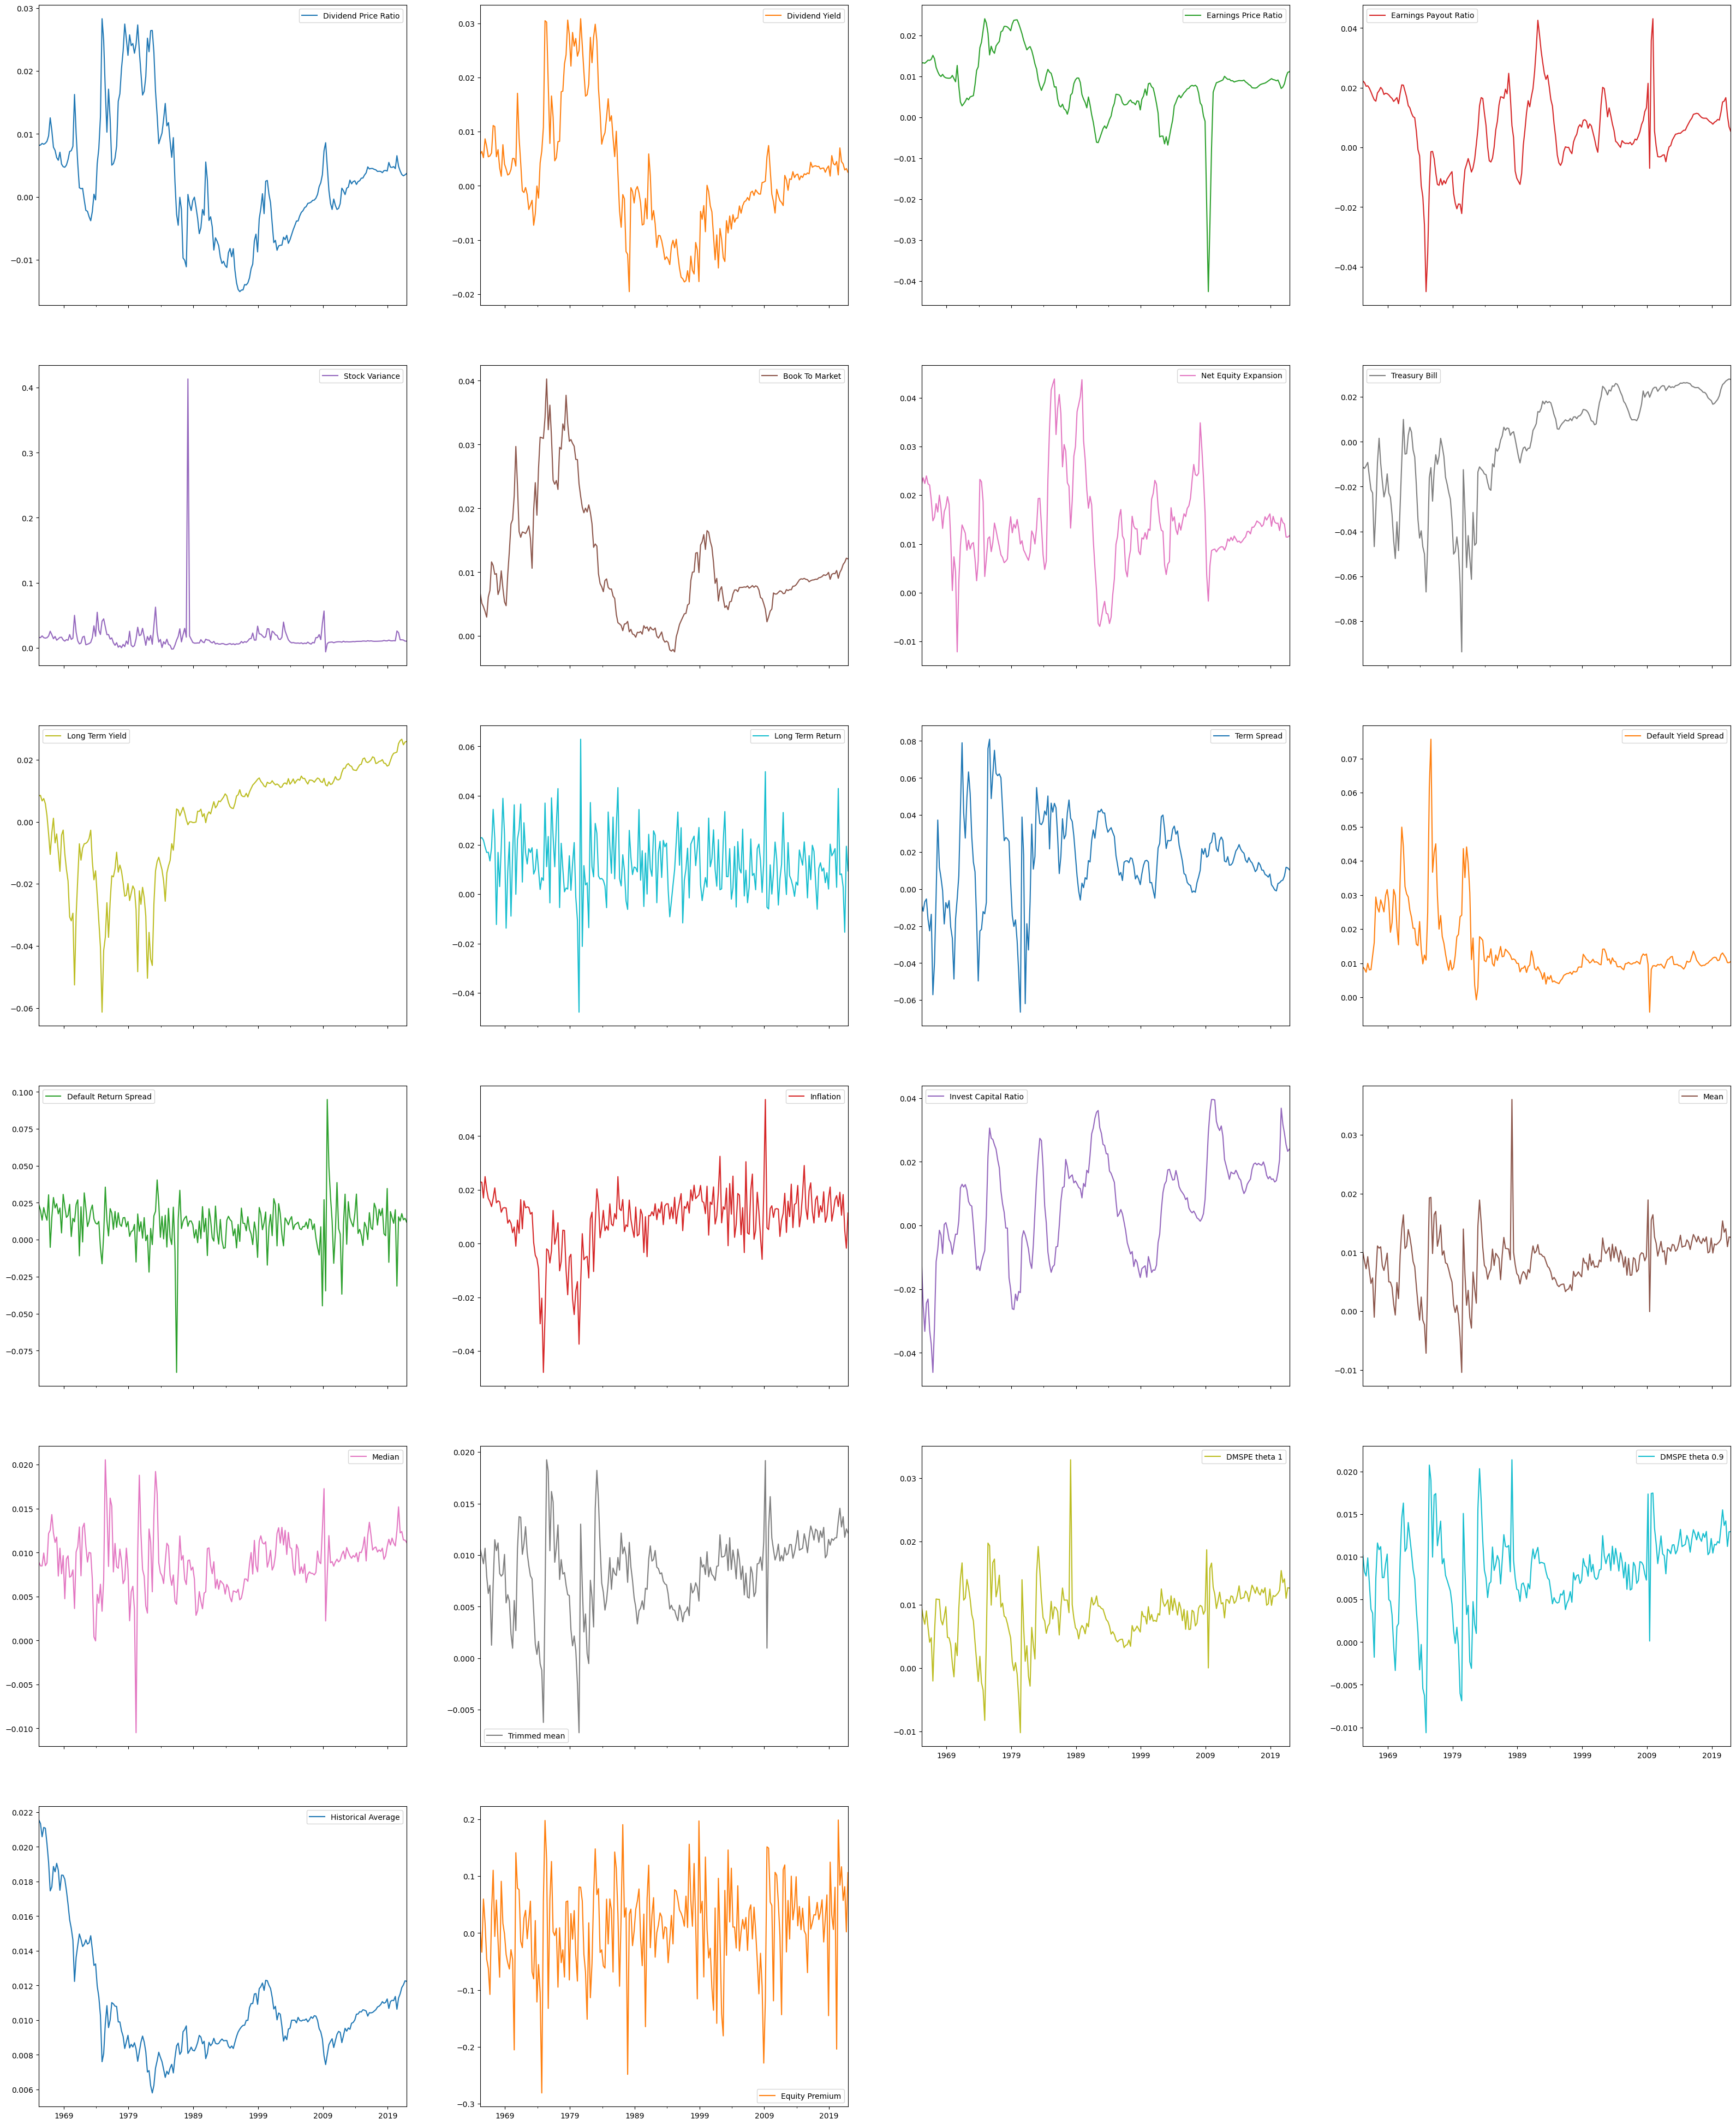

In [10]:
prediction_total.plot(subplots = True,
                        use_index = True,
                        fontsize = 10,
                        layout = (6,4), 
                        figsize = (40,50))

In [14]:
prediction_total.to_csv('../../data/prediction_linear_quarterly_1947_1965_2021.csv')